In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import copy
import csv
import decimal
import json
import os
import pickle
import typing
from collections import Counter, defaultdict
from copy import deepcopy
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Set, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as pil_img
import seaborn as sns
import simdjson as json
from IPython.display import display
from PIL import Image

# If you are using normal pycocotools you will need to comment out these three lines and replace with just: from pycocotools.coco import COCO
from pycocotools.coco import COCO, Ann, Cat, Image, Ref
from pycocotools.helpers import CocoClassDistHelper, CocoJsonBuilder
from pycocotools.helpers.coco_builder import COCOShrinker
from tqdm.auto import tqdm

/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pathlib import Path

from pycocotools.coco import COCO

VALID_SPLITS = {
    # "R-refcoco": ["unc"],
    # "R-refcoco+": ["unc"],
    # "R-refcocog": ["umd"],
    # "refclef": ["berkeley", "unc"],
    "refcoco": ["unc", "google"],
    "refcoco+": ["unc"],
    "refcocog": [
        "umd",
        "google",
    ],  # ["google", "umd"], # google and umd are identical, but have differet train/val/test splits.
    # "coconegref": ["berkeley"],
    "fprefcoco_v002": ["berkeley", "unc", "google"],
    "fprefcoco+_v002": ["berkeley", "unc"],
    "fprefcocog_v002": ["berkeley", "umd", "google", "umd"],
}


def build_refcoco(refseg_path: Path, dataset_name: str, split_by: str = None) -> COCO:
    assert dataset_name in VALID_SPLITS, dataset_name
    if split_by is None:
        split_by = VALID_SPLITS[dataset_name][0]
    else:
        assert (
            split_by.replace("_enhanced", "").replace("_exclude_unified", "")
            in VALID_SPLITS[dataset_name]
        ), f"Did you mean split_by={VALID_SPLITS[dataset_name]}"
    coco = COCO(
        refseg_path / dataset_name / "instances.json",
        is_ref_dataset=True,
        dataset_name=dataset_name,
        split_by=split_by,
    )
    return coco


IMG_DIR = Path("/shared/gbiamby/data/coco/train2014")
REFSEG_DIR = Path("/shared/gbiamby/data/refer_seg")
# REFSEG_DIR = Path("output/ref_seg")
refcoco = build_refcoco(REFSEG_DIR, "fprefcoco+_v002", "berkeley_exclude_unified")

Loading refs from '/shared/gbiamby/data/refer_seg/fprefcoco+_v002/refs(berkeley_exclude_unified).p'
Loaded 49856 refs
loading annotations into memory...
Done (t=2.89s)
creating index...
index created!


In [43]:
# import spacy


# def get_sentence_lookup(refcoco: COCO, search_sent: str):
#     sent_lookup = {}
#     counter = Counter()
#     for image_id, refs in refcoco.img_to_refs.items():
#         for ref in refs:
#             # if image_id == 376848:
#             #     print(f"Found ref with {len(ref['sentences'])} sentences")
#             counter.update({len(ref["sentences"]): 1})
#             for sent_idx, sent in enumerate(ref["sentences"]):
#                 sent_lookup[(image_id, ref["ref_id"], sent_idx)] = sent
#                 for k, v in sent.items():
#                     if isinstance(v, spacy.tokens.Doc):
#                         print("Found Doc1: ", k)
#                         return
#                     if isinstance(v, list) and len(v) > 0:
#                         if isinstance(v[0], spacy.tokens.Doc):
#                             print("Found Doc2: ", k)
#                             return
#                 # if image_id == 376848 and sent["sent"] == search_sent:
#                 #     print("sent: ", sent["sent"])
#                 #     print("ref: ", [s["sent"] for s in ref["sentences"]])
#                 #     print("image: ", image_id)
#     print(counter)
#     return sent_lookup


# print("ds: ", ds)
# refcoco = build_refcoco(REFSEG_DIR, "fprefcocog_v002", "berkeley_exclude_unified")
# lookup = get_sentence_lookup(refcoco, "lady in blue")

ds:  fprefcocog_v002
Loading refs from '/shared/gbiamby/data/refer_seg/fprefcocog_v002/refs(berkeley_exclude_unified).p'
Loaded 49822 refs
loading annotations into memory...
Done (t=1.15s)
creating index...
index created!
Counter({4: 42111, 2: 5070, 3: 2319, 1: 243, 6: 71, 5: 8})


In [42]:
# def fix_refg(refcoco: COCO):
#     print("dataset name: ", refcoco.dataset_name)
#     refs_path = REFSEG_DIR / "fprefcocog_v002/refs(berkeley_exclude_unified).p"
#     assert refs_path.exists()

#     refs_data = refcoco.refs_data
#     for ref in refs_data:
#         for sent in ref["sentences"]:
#             if "spcy_ENTS" not in sent:
#                 continue
#             ents = sent["spcy_ENTS"]
#             if len(ents) < 1:
#                 continue
#             ents = [str(ent).strip() for ent in ents]
#             sent["spcy_ENTS"] = ents
#     with open(refs_path, "wb") as file:
#         pickle.dump(refs_data, file)


# fix_refg(refcoco)

dataset name:  fprefcocog_v002


In [240]:
def show_coco_image(image_id: int, refcoco: COCO):
    for ref in refcoco.img_to_refs[image_id]:
        print(f"ref_id: {ref['ref_id']}, split: {ref['split']}")
        refcoco.showRef(ref)
        plt.show()
        plt.close()


# show_coco_image(376848, refcoco)

---

## Show CLAIR scores

In [180]:
def get_clair_results_df(preds_path: Path):
    with open(preds_path, "r") as json_file:
        raw_data = json.load(json_file)
    results = []
    for idx, r in enumerate(raw_data):
        # if idx == 0:
        #     print(r.keys())

        result = deepcopy(r)
        result["sentence"] = result["sent"]["sent"]
        result["gt_sentence"] = result["sent"]["gt_sent"]
        result["change_type"] = result["sent"]["change_type"]

        del result["ref_gt_sents"]
        del result["img_gt_sents"]
        del result["sent"]
        result["ref_gt_sents"] = [s["sent"] for s in r["ref_gt_sents"]]
        result["img_gt_sents"] = [s["sent"] for s in r["img_gt_sents"]]
        results.append(result)
    print("num results: ", len(raw_data))
    df = pd.DataFrame(results)

    return df


clair_results_paths = [
    # "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores/fprefcocog|berkeley_exclude_unified|val-clair_scores.json",
    # "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_phrase_match/fprefcocog|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    # "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_no_api/fprefcocog|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    # ours:
    "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_001/fprefcoco|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_001/fprefcoco+|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_001/fprefcocog|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    # ours:
    # "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_cascading_001/fprefcoco|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    # "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_cascading_001/fprefcoco+|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    # "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_cascading_001/fprefcocog|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
]
dfs = []
for p in clair_results_paths:
    ds_name = Path(p).stem.split("|")[0]
    print("loading clair results for ", ds_name)
    df = get_clair_results_df(p)
    df.insert(0, "ds", ds_name)
    dfs.append(df)
df = pd.concat(dfs)

loading clair results for  fprefcoco
num results:  6117
loading clair results for  fprefcoco+
num results:  6132
loading clair results for  fprefcocog
num results:  4658


In [134]:
print(len(df))
pd.options.display.float_format = "{:,.2f}".format
pd.set_option("display.max_colwidth", None)

df.head(3)

6117


,ds,clair_candidates,clair_reason,clair_reference_set,clair_score,conversation,gt_exist,image_id,pred_exist,pred_sent,ref_id,ref_split,sent_idx,sentence,gt_sentence,change_type,ref_gt_sents,img_gt_sents
0,fprefcoco,[],SEG token present,"[woman feeding animal, woman in green shirt, woman feeding geraff]",0.00,"Please segment far right person in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.",False,365427,True,"Sure, it is [SEG] .",18660,val,2,far right person,far left person,other_subject,"[woman feeding animal, woman in green shirt, woman feeding geraff]","[far left person, lady in white on left, woman feeding animal, woman in green shirt, woman feeding geraff]"
1,fprefcoco,[],SEG token present,"[woman feeding animal, woman in green shirt, woman feeding geraff]",0.00,"Please segment lady in black on left in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.",False,365427,True,"Sure, lady in black on left is present. Here's the segment: [SEG] .",18660,val,3,lady in black on left,lady in white on left,other_subject,"[woman feeding animal, woman in green shirt, woman feeding geraff]","[far left person, lady in white on left, woman feeding animal, woman in green shirt, woman feeding geraff]"
2,fprefcoco,[],SEG token present,"[woman feeding animal, woman in green shirt, woman feeding geraff]",0.00,"Please segment woman petting animal in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.",False,365427,True,"Sure, the segmentation result is [SEG] .",18660,val,3,woman petting animal,woman feeding animal,other_subject,"[woman feeding animal, woman in green shirt, woman feeding geraff]","[far left person, lady in white on left, woman feeding animal, woman in green shirt, woman feeding geraff]"


In [18]:
# pd.options.display.float_format = "{:,.2f}".format
# pd.set_option("display.max_colwidth", None)
# pd.set_option("display.max_rows", None)

# display(
#     df[
#         [
#             "clair_score",
#             "clair_reason",
#             "clair_candidates",
#             "clair_reference_set",
#             "gt_exist",
#             "pred_sent",
#             "sentence",
#             "gt_sentence",
#             "change_type",
#         ]
#     ].sort_values("clair_score", ascending=False)
# )

In [36]:
display(df.info())
display(df.clair_score.describe())
display(df.image_id.describe())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 16907 entries, 0 to 4657
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ds                   16907 non-null  object 
 1   clair_candidates     16907 non-null  object 
 2   clair_reason         16907 non-null  object 
 3   clair_reference_set  16907 non-null  object 
 4   clair_score          16907 non-null  float64
 5   conversation         16907 non-null  object 
 6   gt_exist             16907 non-null  bool   
 7   image_id             16907 non-null  int64  
 8   pred_exist           16907 non-null  bool   
 9   pred_sent            16907 non-null  object 
 10  ref_id               16907 non-null  int64  
 11  ref_split            16907 non-null  object 
 12  sent_idx             16907 non-null  int64  
 13  sentence             16907 non-null  object 
 14  gt_sentence          16907 non-null  object 
 15  change_type          16907 non-null  objec

None

count   16,907.00
mean         0.23
std          0.38
min          0.00
25%          0.00
50%          0.00
75%          0.50
max          1.00
Name: clair_score, dtype: float64

count    16,907.00
mean    291,284.39
std     168,000.25
min         309.00
25%     143,258.00
50%     290,354.00
75%     439,991.00
max     581,670.00
Name: image_id, dtype: float64

,clair_score,image_id,ref_id,sent_idx
count,"16,907.00","16,907.00","16,907.00","16,907.00"
mean,0.23,"291,284.39","27,136.74",3.43
std,0.38,"168,000.25","14,300.08",1.06
min,0.00,309.00,2.00,1.00
25%,0.00,"143,258.00","14,526.00",3.00
50%,0.00,"290,354.00","28,446.00",3.00
75%,0.50,"439,991.00","39,806.00",4.00
max,1.00,"581,670.00","49,811.00",7.00


In [43]:
assert df.ref_split.nunique() == 1
df_neg = (
    df[~df.gt_exist]
    .copy(deep=True)
    .reset_index(drop=True)
    .drop(columns=["gt_exist", "ref_split"])
)
df_pos = (
    df[df.gt_exist]
    .copy(deep=True)
    .reset_index(drop=True)
    .drop(columns=["gt_exist", "ref_split"])
)

df_neg.head(3)

,ds,clair_candidates,clair_reason,clair_reference_set,clair_score,conversation,image_id,pred_exist,pred_sent,ref_id,sent_idx,sentence,gt_sentence,change_type,ref_gt_sents,img_gt_sents
0,fprefcoco,[],SEG token present,"[woman feeding animal, woman in green shirt, woman feeding geraff]",0.00,"Please segment far right person in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.",365427,True,"Sure, it is [SEG] .",18660,2,far right person,far left person,other_subject,"[woman feeding animal, woman in green shirt, woman feeding geraff]","[far left person, lady in white on left, woman feeding animal, woman in green shirt, woman feeding geraff]"
1,fprefcoco,[],SEG token present,"[woman feeding animal, woman in green shirt, woman feeding geraff]",0.00,"Please segment lady in black on left in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.",365427,True,"Sure, lady in black on left is present. Here's the segment: [SEG] .",18660,3,lady in black on left,lady in white on left,other_subject,"[woman feeding animal, woman in green shirt, woman feeding geraff]","[far left person, lady in white on left, woman feeding animal, woman in green shirt, woman feeding geraff]"
2,fprefcoco,[],SEG token present,"[woman feeding animal, woman in green shirt, woman feeding geraff]",0.00,"Please segment woman petting animal in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.",365427,True,"Sure, the segmentation result is [SEG] .",18660,3,woman petting animal,woman feeding animal,other_subject,"[woman feeding animal, woman in green shirt, woman feeding geraff]","[far left person, lady in white on left, woman feeding animal, woman in green shirt, woman feeding geraff]"


In [88]:
df_neg["has_seg_token"] = df_neg.apply(lambda row: "SEG" in row["clair_reason"], axis=1)
df_neg["has_candidate"] = df_neg.apply(
    lambda row: len(row["clair_candidates"][0]) > 0
    if len(row["clair_candidates"]) > 0
    else False,
    axis=1,
)
df_neg["clair_score_adj"] = df_neg.apply(
    lambda row: row["clair_score"]
    if row["has_candidate"]
    else 1.0
    if "but" not in row["pred_sent"] and "No regex" in row["clair_reason"]
    else 0,
    axis=1,
)

print("Results where model predicts a segmentation for a false premise:")
display(
    df_neg[df_neg.has_seg]
    .groupby(["ds"])
    .agg(
        total_predictions=("clair_score", "count"),
        avg_score=("clair_score", "mean"),
        score_stdev=("clair_score", "std"),
    )
)
print("Results where model does NOT predict a segmentation for a false premise:")
display(
    df_neg[~df_neg.has_seg]
    .groupby(["ds"])
    .agg(
        total_predictions=("clair_score", "count"),
        avg_score=("clair_score", "mean"),
        score_stdev=("clair_score", "std"),
        avg_adj_scorej=("clair_score_adj", "mean"),
        adj_score_stdev=("clair_score_adj", "std"),
    )
)

Results where model predicts a segmentation for a false premise:


,total_predictions,avg_score,score_stdev
ds,,,
fprefcoco,2326,0.00,0.00
fprefcoco+,2338,0.00,0.00
fprefcocog,1563,0.00,0.00


Results where model does NOT predict a segmentation for a false premise:


,total_predictions,avg_score,score_stdev,avg_adj_scorej,adj_score_stdev
ds,,,,,
fprefcoco,3791,0.29,0.41,0.63,0.44
fprefcoco+,3794,0.33,0.42,0.61,0.44
fprefcocog,3095,0.49,0.43,0.67,0.40


array([<Axes: title={'center': 'fprefcoco'}, ylabel='Frequency'>,
       <Axes: title={'center': 'fprefcoco+'}, ylabel='Frequency'>,
       <Axes: title={'center': 'fprefcocog'}, ylabel='Frequency'>],
      dtype=object)

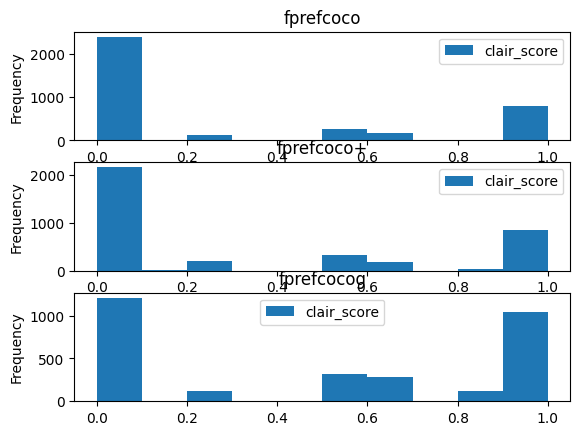

In [90]:
# display(df_neg[["ds", "clair_score"]].plot.hist(by="ds"))
display(df_neg[~df_neg.has_seg][["ds", "clair_score"]].plot.hist(by="ds"))

array([<Axes: title={'center': 'fprefcoco'}, ylabel='Frequency'>,
       <Axes: title={'center': 'fprefcoco+'}, ylabel='Frequency'>,
       <Axes: title={'center': 'fprefcocog'}, ylabel='Frequency'>],
      dtype=object)

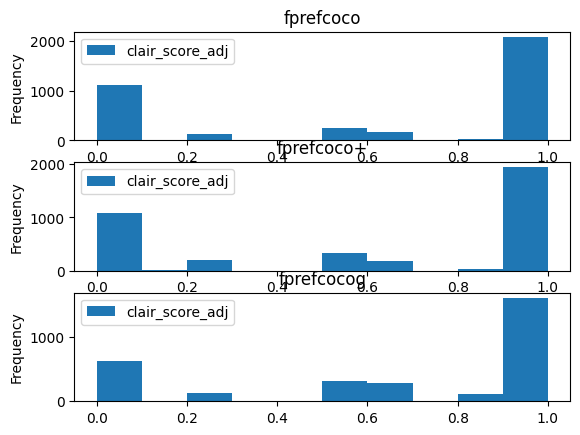

In [91]:
# display(df_neg[["ds", "clair_score_adj"]].plot.hist(by="ds"))
display(df_neg[~df_neg.has_seg][["ds", "clair_score_adj"]].plot.hist(by="ds"))

In [94]:
print("Results where model does NOT predict a segmentation for a false premise:")
display(
    df_neg[~df_neg.has_seg]
    .groupby(["ds", "has_candidate"])
    .agg(
        total_predictions=("clair_score", "count"),
        avg_score=("clair_score", "mean"),
        score_stdev=("clair_score", "std"),
    )
)

Results where model does NOT predict a segmentation for a false premise:


total_predictions  avg_score  score_stdev
ds         has_candidate                                           
fprefcoco  False                       1302       0.00         0.00
           True                        2489       0.44         0.44
fprefcoco+ False                       1100       0.00         0.00
           True                        2694       0.46         0.43
fprefcocog False                        588       0.00         0.00
           True                        2507       0.60         0.40

In [95]:
# Display
pd.options.display.float_format = "{:,.2f}".format
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

df_temp = df_neg[
    (~df_neg.has_seg)
    & (df_neg.clair_score == 0)
    & (~df_neg.has_candidate)
    & (df_neg.clair_score_adj == 0)
][
    [
        "clair_candidates",
        "clair_reason",
        "clair_reference_set",
        "clair_score",
        "clair_score_adj",
        "conversation",
        "pred_sent",
        "sentence",
        "gt_sentence",
    ]
].sort_values(
    "clair_score_adj"
)
print(len(df_temp))
display(df_temp)

52


,clair_candidates,clair_reason,clair_reference_set,clair_score,clair_score_adj,conversation,pred_sent,sentence,gt_sentence
325,[],No regex match,"[appliances inf front of man bottom right, bottom frige in front of girl]",0.00,0.00,"Please segment machines inf front of man bottom right in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.","Yes, I see it. Segment machines inf front of man bottom right is present. Segment machines inf front of man bottom right is not in the shot, but take a look at refrigerators inf front of man bottom right.",machines inf front of man bottom right,appliances inf front of man bottom right
8536,[],No regex match,"[white girl, white person, white girl]",0.00,0.00,"Please segment boy in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.","boy is not detected, but girl is.",boy,girl
9069,[],No regex match,"[can see almost all of this zebra, zebra standing, zebra in gate]",0.00,0.00,"Please segment can see almost all of this unicorn in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.","Can't spot can see almost all of this unicorn, but can see almost all of this zebra is in the frame.",can see almost all of this unicorn,can see almost all of this zebra
9204,[],No regex match,"[tallest giraffe, giraffe facing forward, tallest]",0.00,0.00,"Please segment closest unicorn butt in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.",No evidence of closest unicorn butt in this visual.,closest unicorn butt,closest giraffe butt
9541,[],,"[table in foreground, coffee table, table]",0.00,0.00,"Please segment dining table in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.","No dining table in sight, but dining table is noticeable.",dining table,coffee table
9695,[],No regex match,"[biggest elephant, largest elephant at end of line, closest to edge elephant and largest one]",0.00,0.00,"Please segment tallest giraffe at end of line in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.","The image doesn't have tallest giraffe at end of line, but it does contain tallest elephant at end of line.",tallest giraffe at end of line,largest elephant at end of line
9803,[],No regex match,"[arms without spiin, arm lonely, arm of person off to side]",0.00,0.00,"Please segment cup of coffee with glitter added in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.","No cup of coffee with glitter found, but you can see cup of coffee with foam.",cup of coffee with glitter added,cup of coffee with cream added
10084,[],No regex match,"[round donut lighter ne, round nutty pastry, large round dessert with swirl and candy pieces]",0.00,0.00,"Please segment short chocolate in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.","Yes, I see it. Segment short chocolate is present. Segment long chocolate is missing, but you'll notice segment short chocolate.",short chocolate,long chocolate
10521,[],No regex match,"[carrot below smallest, carrot above knife with head up, short carrot near knife with step facing away]",0.00,0.00,"Please segment fattest banana in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.","The image doesn't have it, but it does contain fattest carrot.",fattest banana,fattest carrot
10539,[],No regex match,"[the board you type on, keyboard, keyboard]",0.00,0.00,"Please segment the table you type on in this image if it exists. Otherwise, tell me the object doesn't exist and optionally offer an alternative.","Yes, I see it. Segment the table you type on is present. Segment the table you type on is not in the shot, but take a look 

---
# Scratch

In [224]:
EXCLUDES = set(
    [
        "NAN-no, this picture doesn't seem to have .",
        "NAN-the image lacks .",
        "NAN-no, this picture doesn't have it.",
        "NAN-no, this picture doesn't have ." "NAN-no, this depiction is devoid of .",
        "NAN-no, this depiction is devoid of .",
        "NAN-no evidence of it in this visual.",
        "NAN-no evidence of in this visual.",
        "NAN-no in sight in this frame.",
        "NAN-no, the image doesn't include it.",
        "NAN-no in sight in this frame.",
        "NAN-no, there's no in this image.",
        "NAN-i don't see it in the image.",
        "NAN-no, there's no in this image.",
        "NAN-i'm not able to spot it here.",
        "NAN-no, the image doesn't include .",
        "NAN-i don't see in the image.",
        "NAN-this image seems to be missing it.",
        "NAN-no in sight in this frame.",
        # llava
        "NAN-no, there are no in the image.",
        """NAN-no, there is no in the image.""",
        "NAN-no, this picture doesn't seem to have it.",
        "NAN-no, there's no in this picture.",
        "NAN-i'm not able to spot here.",
        "NAN-no, this picture doesn't seem to have any .",
        "NAN-no sign of in the image.",
        "NAN-the image doesn't feature .	",
        "NAN-i can't find in this image.",
        "NAN-no, this picture doesn't seem to have segment .",
        "NAN-no, this picture doesn't have .",
        "NAN-no, this picture doesn't seem to have in it.",
        "NAN-this image is devoid of any .",
        "NAN-no evidence of it found.",
        "",
        "",
        "",
    ]
)
EXCLUDES = {e.strip() for e in EXCLUDES}

In [291]:
import regex as re


def check_match(pattern: str, pred_sent: str):
    if re.match(pattern, pred_sent):
        result = re.match(pattern, pred_sent, flags=re.IGNORECASE)
        return True, result
    return (False, None)


def scrub_lisa_pred_for_clair_scoring(row):
    pred_sent = row["pred_sent"].replace(row["sentence"], "").lower()
    patterns = [
        ".*?(however[,]{0,1})(?P<pred_correction>.*?)\\s*(is present)",
        "no.*?(but the image does have){1,1}(?P<pred_correction>.*)(in there){0,1}[\\s\\.]{0,1}$",
        "no.*?(but take a look at the|but take a look at){1,1}(?P<pred_correction>.*)(in there)",
        "(the).*?(isn't in this image, but|in sight, but|but do take note of|is missing, but you'll notice)(?P<pred_correction>.*?)(is){0,1}[\\s\\.]{0,1}$",
        "(no|the).*?(but do take note of|found, but you can see){1,1}(?P<pred_correction>.*)",
        "(no)[,\\s]*.*?(in sight, but|in sight)(?P<pred_correction>.*)is noticeable[\\s\\.]{0,1}",
        ".*?(isn't in the picture, instead, it's)(?P<pred_correction>.*)",
        ".*?(isn't in the shot, but|but the image does feature)(?P<pred_correction>.*?)(is){0,1}[\\s\\.]{0,1}$",
        "no sign of.*?(but)(?P<pred_correction>.*?)(can be see instead){0,1}[\\s\\.]{0,1}$",
        "no evidence of.*?(but don't miss|but check out the|but check out)(?P<pred_correction>.*?)(instead){0,1}[\\s\\.]{0,1}$",
        "no trace of.*?(but don't miss)(?P<pred_correction>.*?)(in the same image){0,1}[\\s\\.]{0,1}$",
        "no.*?(but you can see a|but take )(?P<pred_correction>.*?)(in the same image){0,1}[\\s\\.]{0,1}$",
        "i don't see.*?(but)(?P<pred_correction>.*?)(is present|is prominently displayed)[\\s\\.]{0,1}$",
        "no.*?(but the image includes|but the|in sight, but|, but a)(?P<pred_correction>.*?)(is there|is in sight|in sight|is present){0,1}[\\s\\.]{0,1}$",
        "the.*?(isn't visible, but|isn't there, but|isn't here, but there's)(?P<pred_correction>.*?)(is present|stands out|in the image|is)[\\s\\.]{0,1}$",
        "the search for.*?(turned up empty, however, you can see)(?P<pred_correction>.*?)(is present){0,1}[\\s\\.]{0,1}$",
        "i can't confirm.*?(but there's|but there is)(?P<pred_correction>.*?)[\\s\\.]{0,1}$",
        "the image lacks.*?(but not|yet showcases)(?P<pred_correction>.*?)[\\s\\.]{0,1}$",
        ".*?(isn't part of the scene, but)(?P<pred_correction>.*?)(is evident)[\\s\\.]{0,1}$",
        ".*?(but)(?P<pred_correction>.*?)(is certainly present)[\\s\\.]{0,1}$",
        ".*?(but there's|but there is|but check out|but the image highlights)(?P<pred_correction>.*?)[\\s\\.]{0,1}$",
        ".*?(but there's|but there is|but check out|but the image highlights|but the image includes|is not present, but|but i do see|but the image clearly shows|however,)(?P<pred_correction>.*?)(is quite evident|is present){0,1}[\\s\\.]{0,1}$",
        ".*?(is absent, but you might be interested in)(?P<pred_correction>.*?)(that's in the picture){0,1}[\\s\\.]{0,1}$",
        ".*?(is not detected, but)(?P<pred_correction>.*?)(is){0,1}[\\s\\.]{0,1}$",
        ".*?(isn't part of this, but)(?P<pred_correction>.*?)(is evident){0,1}[\\s\\.]{0,1}$",
        ".*?(is not in the shot, but take a look at|doesn't appear, but you can see|doesn't feature, but you can see|but it does contain)(?P<pred_correction>.*?)[\\s\\.]{0,1}$",
        ".*?(but can see)(?P<pred_correction>.*?)(is evident|is in the frame){0,1}[\\s\\.]{0,1}$",
    ]
    for idx, pat in enumerate(patterns):
        is_match, match = check_match(pat, pred_sent)
        if is_match:
            if match and match.groupdict() and "pred_correction" in match.groupdict():
                return str(match.groupdict()["pred_correction"])
            else:
                return f"ERROR: {match}"
    while "  " in pred_sent:
        pred_sent = pred_sent.replace("  ", " ")
    return f"NAN-{pred_sent}".strip()


def scrub_llava_pred_for_clair_scoring(row):
    pred_sent = row["pred_sent"].replace(row["sentence"], "").lower()
    patterns = [
        "no, there are no[^\\.]*?\\.\\s*(?P<pred_correction>.+)[\\s\\.]{0,1}$",
        "no, [^\\.]*?\\.\\s*(?P<pred_correction>.+)[\\s\\.]{0,1}$",
    ]
    for idx, pat in enumerate(patterns):
        is_match, match = check_match(pat, pred_sent)
        if is_match:
            if match and match.groupdict() and "pred_correction" in match.groupdict():
                return str(idx) + ": " + str(match.groupdict()["pred_correction"])
            else:
                return f"ALMOST: {match}"

    return f"NAN-{pred_sent}".strip()


def adjust_clair_score(row):
    if row["has_seg_token"]:
        return 0
    elif row["fp_correction"].startswith("NAN-yes"):
        return 0
    elif not (
        row["fp_correction"].startswith("NAN-") or "ERROR" in row["fp_correction"]
    ):
        return row["clair_score"]
    elif (
        row["fp_correction"].startswith("NAN-no")
        or "i don't see" in row["fp_correction"]
        or "missing it" in row["fp_correction"]
        or "image is devoid of" in row["fp_correction"]
        or "image seems to be missing" in row["fp_correction"]
        or "image doesn't feature" in row["fp_correction"]
        or "not able to spot" in row["fp_correction"]
        or "can't find" in row["fp_correction"]
        or "fails to display" in row["fp_correction"]
        or "doesn't seem to feature" in row["fp_correction"]
        or "the image lacks" in row["fp_correction"]
        # or "" in row["fp_correction"]
        # or "" in row["fp_correction"]
    ) and not ("but, " in row["fp_correction"] or "however" in row["fp_correction"]):
        return 1.0
    return None
    return row["clair_score"]


def get_clair_scores_lisa(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(deep=True)
    print(f"Processing {len(df)} results")
    print(f"Num pos: {len(df[df.gt_exist])}, num negative: {len(df[~df.gt_exist])}")
    df_fp = df[~df.gt_exist]
    df_fp["has_seg_token"] = df_fp.pred_sent.apply(lambda row: "[SEG]" in row.upper())
    print(
        f"has_seg_token:{len(df_fp[df_fp.has_seg_token])}, NO_seg_token:{len(df_fp[~df_fp.has_seg_token])}"
    )
    df_fp["fp_correction"] = df_fp.apply(
        lambda row: scrub_lisa_pred_for_clair_scoring(row), axis=1
    )
    df_fp["has_fp_correction"] = df_fp.fp_correction.apply(
        lambda c: len(c) > 0 and not c.startswith("NAN-")
    )
    df_fp["is_fp_correction_whitelisted"] = df_fp.fp_correction.apply(
        lambda corr: corr in EXCLUDES
    )
    df_fp["clair_score_adj"] = df_fp.apply(lambda row: adjust_clair_score(row), axis=1)
    df_fp["has_final_score"] = df_fp.clair_score_adj.apply(lambda cs: not pd.isna(cs))
    df_fp["has_candidate"] = df_fp.apply(
        lambda row: len(row["clair_candidates"][0]) > 0
        if len(row["clair_candidates"]) > 0
        else False,
        axis=1,
    )
    df_noscore = df_fp[~df_fp.has_final_score]

    df_no_correction = df_fp[
        (~df_fp.fp_correction.isin(EXCLUDES)) & (~df_fp.has_seg_token)
    ]
    df_no_correction = df_no_correction[
        df_no_correction.fp_correction.str.startswith("NAN-")
    ]
    print(f"Found {len(df_no_correction)} results with no pred_correction")
    print("df_fp.shape: ", df_fp.shape)
    return (
        df_fp.reset_index(drop=True),
        df_no_correction.reset_index(drop=True),
        df_noscore.reset_index(drop=True),
    )


def get_clair_scores_llava(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(deep=True)
    return df

# Scoring for LLAVA Model

In [ ]:
df_scores, df_no_correction, df_noscore = get_clair_scores_lisa(df)

print(
    "df_scores.shape: ",
    df_scores.shape,
    ", df_no_correction.shape: ",
    df_no_correction.shape,
)

# Display
# display(df_no_correction.head(5))
# pd.options.display.float_format = "{:,.2f}".format
# pd.set_option("display.max_colwidth", None)
# pd.set_option("display.max_rows", None)
# display(
#     pd.DataFrame(df_no_correction.groupby(["fp_correction"]).agg(total=("pred_sent", "count")))
#     .reset_index()
#     .sort_values("total", ascending=False)
#     .head(20)
# )

output_cols = [
    "has_final_score",
    "clair_score",
    "clair_score_adj",
    "pred_sent",
    "sentence",
    "gt_sentence",
    "fp_correction",
    # "pred_exist", # ignore this, it's just a simple `is "no" in prediction' that comes from the eval script
]
display(
    pd.DataFrame(
        df_scores.groupby(
            ["ds", "has_final_score", "is_fp_correction_whitelisted"], dropna=False
        ).agg(total=("pred_sent", "count"))
    )
    .reset_index()
    .head(20)
)
print("no scores: ", len(df_noscore))
display(
    pd.DataFrame(
        df_noscore.groupby(
            ["ds", "has_final_score", "is_fp_correction_whitelisted"], dropna=False
        ).agg(total=("pred_sent", "count"))
    )
    .reset_index()
    .head(20)
)

display(
    pd.DataFrame(
        df_scores.groupby(["ds", "has_fp_correction"], dropna=False).agg(
            total=("pred_sent", "count")
        )
    )
    .reset_index()
    .head(20)
)
display(df_noscore[output_cols].sort_values("fp_correction", ascending=False))

print("Final Scores: ", len(df_scores))
display(
    pd.DataFrame(
        df_scores.groupby(["has_seg_token", "ds"], dropna=False).agg(
            clair_score_adj=("clair_score_adj", "mean"),
            clair_score_stdev=("clair_score_adj", "std"),
        )
    )
    .reset_index()
    .head(20)
)

# Scoring for "Hollistic (Ours)" Model:

In [291]:
df_scores, df_no_correction, df_noscore = get_clair_scores_lisa(df)

print(
    "df_scores.shape: ",
    df_scores.shape,
    ", df_no_correction.shape: ",
    df_no_correction.shape,
)

# Display
# display(df_no_correction.head(5))
# pd.options.display.float_format = "{:,.2f}".format
# pd.set_option("display.max_colwidth", None)
# pd.set_option("display.max_rows", None)
# display(
#     pd.DataFrame(df_no_correction.groupby(["fp_correction"]).agg(total=("pred_sent", "count")))
#     .reset_index()
#     .sort_values("total", ascending=False)
#     .head(20)
# )

output_cols = [
    "has_final_score",
    "clair_score",
    "clair_score_adj",
    "pred_sent",
    "sentence",
    "gt_sentence",
    "fp_correction",
    # "pred_exist", # ignore this, it's just a simple `is "no" in prediction' that comes from the eval script
]
display(
    pd.DataFrame(
        df_scores.groupby(
            ["ds", "has_final_score", "is_fp_correction_whitelisted"], dropna=False
        ).agg(total=("pred_sent", "count"))
    )
    .reset_index()
    .head(20)
)
print("no scores: ", len(df_noscore))
display(
    pd.DataFrame(
        df_noscore.groupby(
            ["ds", "has_final_score", "is_fp_correction_whitelisted"], dropna=False
        ).agg(total=("pred_sent", "count"))
    )
    .reset_index()
    .head(20)
)

display(
    pd.DataFrame(
        df_scores.groupby(["ds", "has_fp_correction"], dropna=False).agg(
            total=("pred_sent", "count")
        )
    )
    .reset_index()
    .head(20)
)
display(df_noscore[output_cols].sort_values("fp_correction", ascending=False))

print("Final Scores: ", len(df_scores))
display(
    pd.DataFrame(
        df_scores.groupby(["has_seg_token", "ds"], dropna=False).agg(
            clair_score_adj=("clair_score_adj", "mean"),
            clair_score_stdev=("clair_score_adj", "std"),
        )
    )
    .reset_index()
    .head(20)
)

Processing 16907 results
Num pos: 0, num negative: 16907
has_seg_token:6227, NO_seg_token:10680
Found 219 results with no pred_correction
df_fp.shape:  (16907, 25)
df_scores.shape:  (16907, 25) , df_no_correction.shape:  (219, 25)


,ds,has_final_score,is_fp_correction_whitelisted,total
0,fprefcoco,True,False,4891
1,fprefcoco,True,True,1226
2,fprefcoco+,True,False,5106
3,fprefcoco+,True,True,1026
4,fprefcocog,True,False,4187
5,fprefcocog,True,True,471


no scores:  0


,ds,has_final_score,is_fp_correction_whitelisted,total


,ds,has_fp_correction,total
0,fprefcoco,False,3607
1,fprefcoco,True,2510
2,fprefcoco+,False,3417
3,fprefcoco+,True,2715
4,fprefcocog,False,2137
5,fprefcocog,True,2521


,has_final_score,clair_score,clair_score_adj,pred_sent,sentence,gt_sentence,fp_correction


Final Scores:  16907


,has_seg_token,ds,clair_score_adj,clair_score_stdev
0,False,fprefcoco,0.63,0.44
1,False,fprefcoco+,0.61,0.44
2,False,fprefcocog,0.67,0.40
3,True,fprefcoco,0.00,0.00
4,True,fprefcoco+,0.00,0.00
5,True,fprefcocog,0.00,0.00


In [310]:
display(
    pd.DataFrame(
        df_scores[(~df_scores.has_seg_token)].groupby(["ds"], dropna=False).agg(
            clair_score_adj=("clair_score_adj", "mean"),
            clair_score_stdev=("clair_score_adj", "std"),
        )
    )
    .reset_index()
    .head(20)
)

,ds,clair_score_adj,clair_score_stdev
0,fprefcoco,0.63,0.44
1,fprefcoco+,0.61,0.44
2,fprefcocog,0.67,0.40


/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

Text(0.5, 0.98, 'CLAIR Scores (including False [SEG] Responses)')

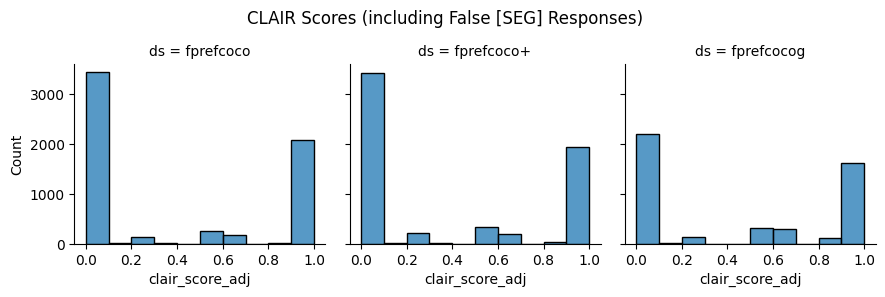

In [308]:
plot = sns.displot(
    df_scores,
    x="clair_score_adj",
    col="ds",
    binwidth=0.1,
    height=3,
    facet_kws=dict(margin_titles=True),
)
plot.fig.subplots_adjust(top=0.8, bottom=0.2)  # adjust the Figure in rp
plot.fig.suptitle("CLAIR Scores (including False [SEG] Responses)")

/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

Text(0.5, 0.98, 'CLAIR Scores (only text reponses)')

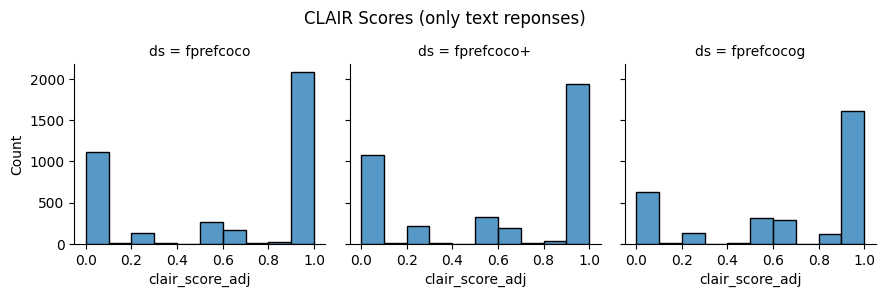

In [306]:
plot = sns.displot(
    df_scores[(~df_scores.has_seg_token)],
    x="clair_score_adj",
    col="ds",
    binwidth=0.1,
    height=3,
    facet_kws=dict(margin_titles=True),
)
plot.fig.subplots_adjust(top=0.8, bottom=0.2)  # adjust the Figure in rp
plot.fig.suptitle("CLAIR Scores (only text reponses)")